# Identifying Address Reference Systems (ARS)

First, a similarity measure for streets is required.

Physical distances between addresses can be problematic because addresses can be located at arbitrary distances apart. One obvious illustration of this can be found in the difference between suburbs and urban areas building densities.

In [145]:
import glob
import json
import urllib
import ntpath
import operator
import functools
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import distance
from itertools import groupby, combinations
from hmmlearn.hmm import GaussianHMM
from IPython.display import Image

%matplotlib inline

ox.config(log_console=True, use_cache=True)

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

### Prepare Street Data

In [11]:
def add_street_prop(filename, street):
    base = ntpath.basename(filename)
    without_ext = base.split('.')[0]
    without_id = without_ext.split('__')[1]
    street_name = urllib.parse.unquote_plus(without_id)
    for x in street:
        x.update({'street': street_name})
    return street

def read_json(file):
    with open(file) as f:
        street = json.load(f)
        return add_street_prop(file, street)

def read_jsons(files):
    return [read_json(f) for f in files]

def dedupe_street(street):
    seen = set()
    return [x for x in street if [(x['street'], x['housenumber'])
                                  not in seen, seen.add((x['street'], x['housenumber']))][0]]

def get_streets(blob):
    files = glob.glob(f'./data/streets/*{blob}*')
    nested = read_jsons(files)
    full = functools.reduce(operator.iconcat, nested, [])
    return dedupe_street(full)

In [12]:
all_streets = get_streets('')

In [13]:
all_streets[:2]

[{'rowid': 357377,
  'id': 14889,
  'source': 'OA',
  'source_id': '4b6fcce92fe852f7',
  'housenumber': 2,
  'lat': 52.5665096,
  'lon': 13.2221506,
  'parity': 'R',
  'proj_lat': 52.5666038704211,
  'proj_lon': 13.221891523899563,
  'marker-color': '#ff0000',
  'marker-symbol': 'e',
  'street': 'Elkartweg'},
 {'rowid': 357378,
  'id': 14889,
  'source': 'OA',
  'source_id': '5dd2114a2c898e3a',
  'housenumber': 3,
  'lat': 52.5666823,
  'lon': 13.2217923,
  'parity': 'L',
  'proj_lat': 52.56663502950204,
  'proj_lon': 13.221922210873217,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Elkartweg'}]

In [14]:
some_streets = all_streets[:50000]

In [48]:
def sort_street(street):
    return sorted(street, key=lambda k: k['housenumber'])

def group_streets(streets):
    grouped_streets = {}
    for k, v in groupby(streets, key=lambda x:x['street']):
        grouped_streets[k] = list(sort_street(v))
    return grouped_streets

def encode_parity(address):
    if address['parity'] == 'R':
        return 0
    else:
        return 1

def create_X(groups):
    X = []
    for value in groups.values():
        X.append([encode_parity(i) for i in value])
    return X

In [170]:
grouped_streets = group_streets(all_streets)
grouped_streets['Sollstedter Straße']

[{'rowid': 86024,
  'id': 31023,
  'source': 'OA',
  'source_id': '34d1a42e672fee26',
  'housenumber': 1,
  'lat': 52.5367362,
  'lon': 13.5061264,
  'parity': 'L',
  'proj_lat': 52.53655284935239,
  'proj_lon': 13.506163861224355,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 86025,
  'id': 31023,
  'source': 'OA',
  'source_id': 'c18b778351216149',
  'housenumber': 3,
  'lat': 52.5367547,
  'lon': 13.5063783,
  'parity': 'L',
  'proj_lat': 52.53657188238236,
  'proj_lon': 13.506415652349999,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 86026,
  'id': 31023,
  'source': 'OA',
  'source_id': '4b770ed1512914ea',
  'housenumber': 5,
  'lat': 52.5367708,
  'lon': 13.5066822,
  'parity': 'L',
  'proj_lat': 52.5365947498345,
  'proj_lon': 13.506718169685563,
  'marker-color': '#3366ff',
  'marker-symbol': 'o',
  'street': 'Sollstedter Straße'},
 {'rowid': 161475,
  'id': 31023,
  'sour

### Plot Pairwise Distances Helper

In [168]:
def address_distance(a1, a2):
    return distance.distance((a1['proj_lat'], a1['proj_lon']), (a2['proj_lat'], a2['proj_lon'])).m

def plot_pairwise_dists(street):
    # Number of unique pairs = N(N-1)/2
    dists = [address_distance(comb[0], comb[1]) for comb in combinations(street, 2)]

    sns.distplot(dists)

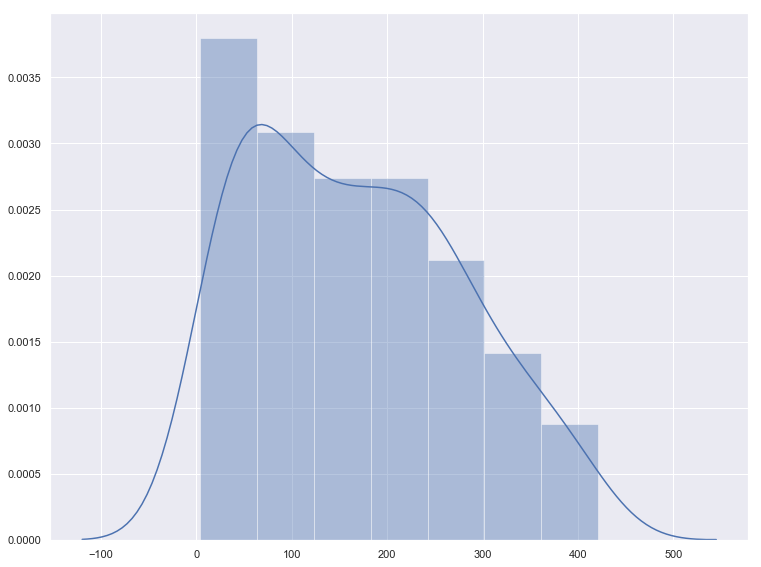

In [169]:
plot_pairwise_dists(grouped_streets['Elkartweg'])

### Plot Streets Helper

In [191]:
def plot_street(streets, name, address, distance=1000):
    street = streets[name]
    lons = [x['proj_lon'] for x in street]
    lats = [x['proj_lat'] for x in street]
    G = ox.graph_from_address(address, distance=distance)
    fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, edge_color='black', node_color='none')
    ax.scatter(lons, lats, c='red', s=20, marker='o')
    # ax.plot(lons, lats, marker='o', markersize=5, color="red")
    # print(ax.get_ylim(), ax.get_xlim())

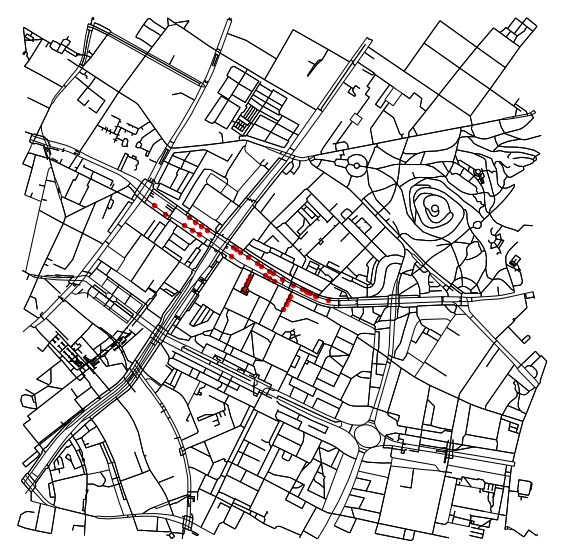

In [192]:
plot_street(grouped_streets, 'Mollstraße', 'Mollstraße, Berlin, Germany')

### Plot Street Examples

#### One-sided Streets

In [197]:
print([i['housenumber'] for i in grouped_streets['Biesenthaler Straße']])

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


In [59]:
ox.geocode('Biesenthaler Straße, Lichtenberg, Berlin, Germany')

(52.537002, 13.5048953)

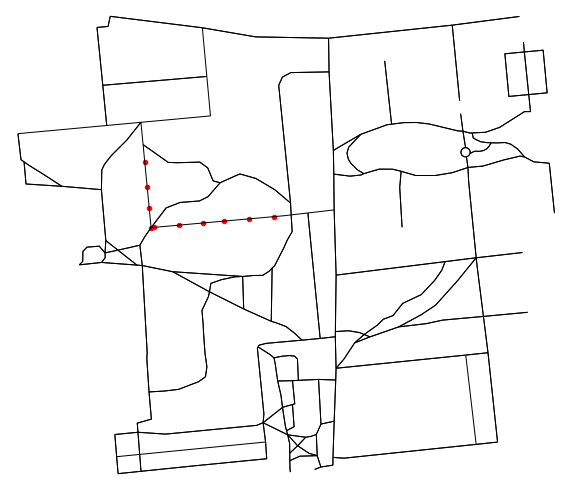

In [193]:
# edge_linewidth=2
plot_street(grouped_streets, 'Biesenthaler Straße', 'Biesenthaler Straße, Lichtenberg, Berlin, Germany', 250)

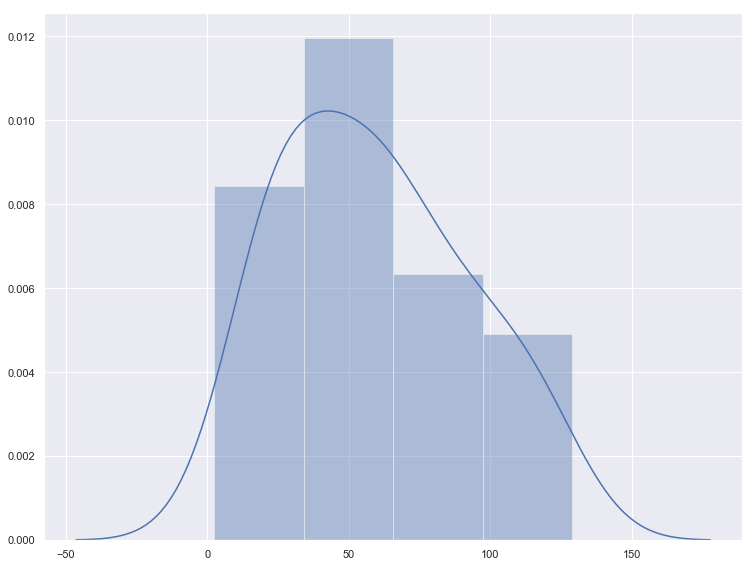

In [172]:
plot_pairwise_dists(grouped_streets['Biesenthaler Straße'])

In [199]:
print([i['housenumber'] for i in grouped_streets['Sollstedter Straße']])

[1, 3, 5, 7]


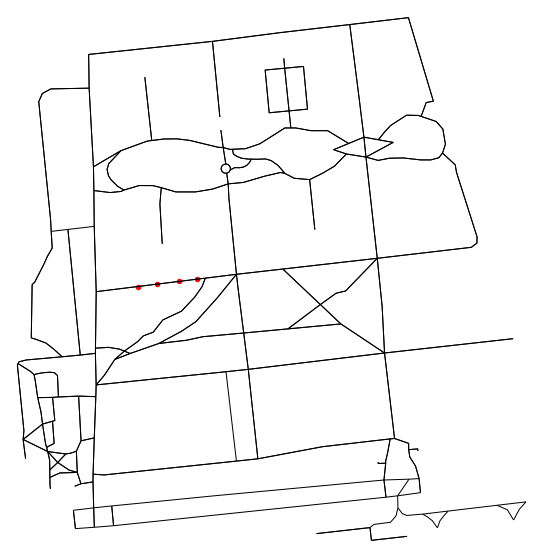

In [200]:
plot_street(grouped_streets, 'Sollstedter Straße', 'Sollstedter Straße, Lichtenberg, Berlin, Germany', 250)

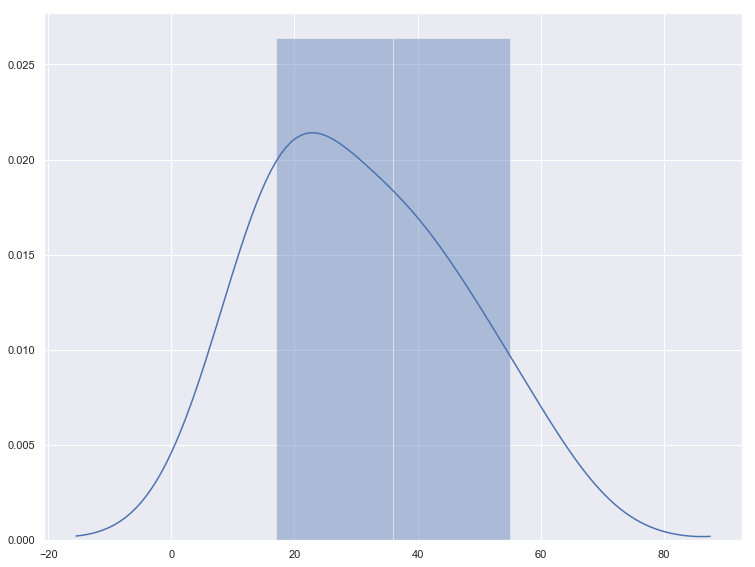

In [201]:
plot_pairwise_dists(grouped_streets['Sollstedter Straße'])

#### Even-Odd Streets

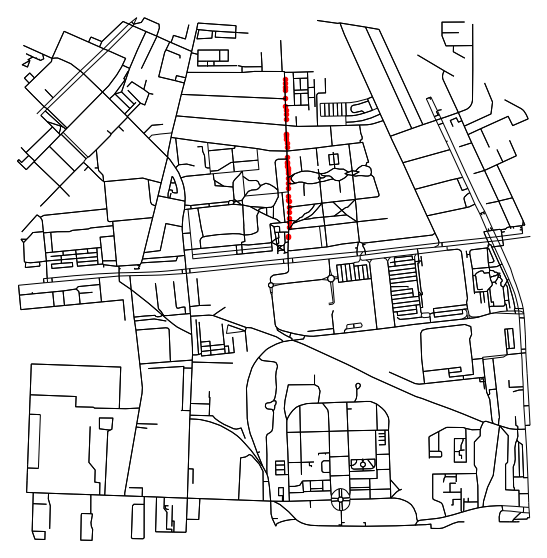

In [194]:
plot_street(grouped_streets, 'Arendsweg', 'Arendsweg, Lichtenberg, Berlin, Germany', 1000)

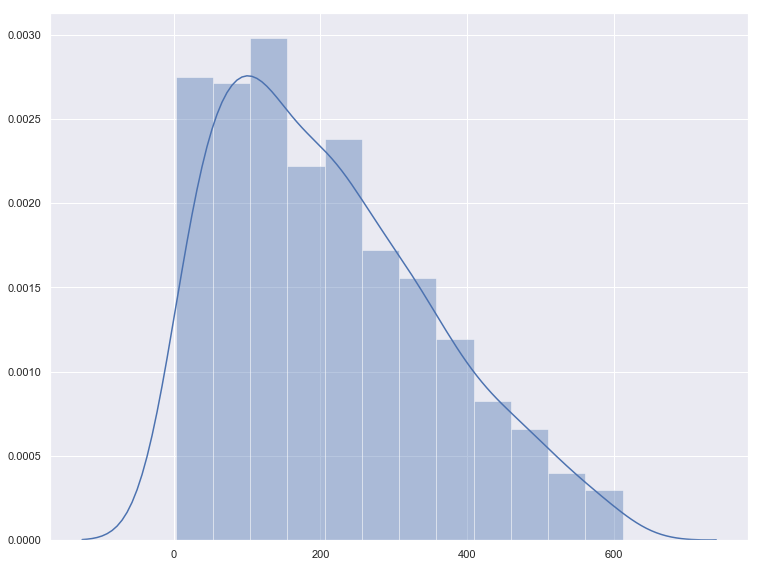

In [173]:
plot_pairwise_dists(grouped_streets['Arendsweg'])

In [129]:
ox.geocode('Arendsweg, Lichtenberg, Berlin, Germany')

(52.5341441, 13.5047197)

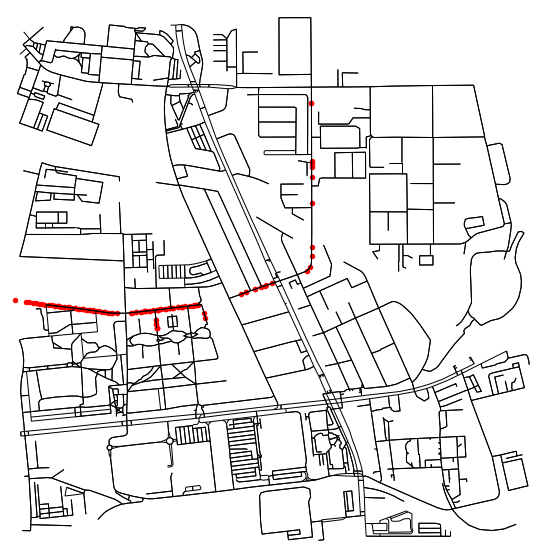

In [195]:
plot_street(grouped_streets, 'Plauener Straße', 'Plauener Straße, Lichtenberg, Berlin, Germany', 1000)

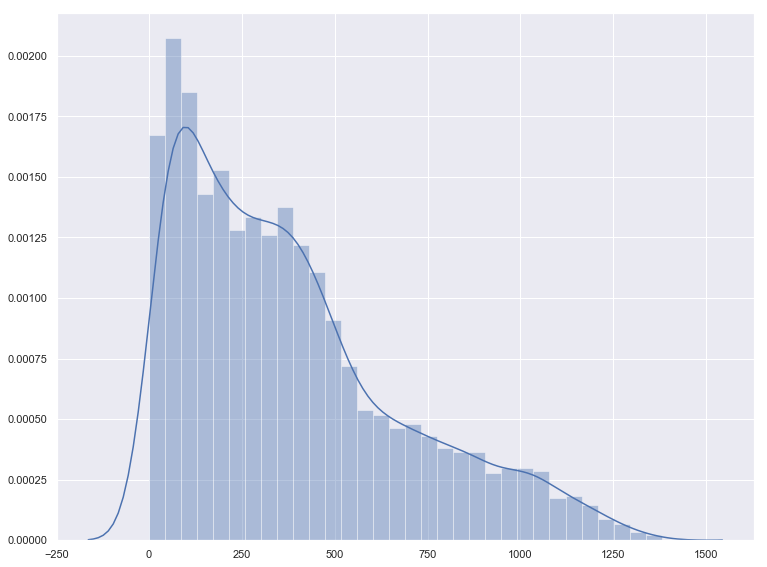

In [196]:
plot_pairwise_dists(grouped_streets['Plauener Straße'])

In [123]:
def make_plot(place, point, network_type='drive', bldg_color='orange', dpi=60,
              dist=805, default_width=4, street_widths=None):
    gdf = ox.buildings_from_point(point=point, distance=dist)
    gdf_proj = ox.project_gdf(gdf)
    fig, ax = ox.plot_figure_ground(point=point, dist=dist, network_type=network_type, default_width=default_width,
                                    street_widths=street_widths, save=False, show=False, close=True)
    fig, ax = ox.plot_buildings(gdf_proj, fig=fig, ax=ax, color=bldg_color, set_bounds=False,
                                save=True, show=False, close=True, filename=place, dpi=dpi)

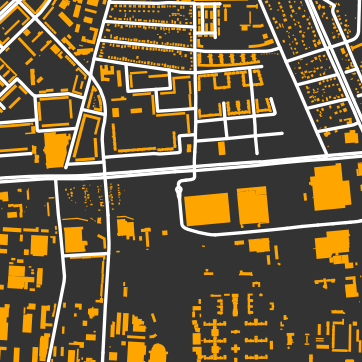

In [130]:
img_folder = 'images'
extension = 'png'
size = 480
place = 'arendsweg_buildings'
point = (52.5341441, 13.5047197)
make_plot(place, point)
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)